In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import itertools
from numba import njit, prange
from sympy import symbols, sqrt, solve, lambdify
from scipy.optimize import minimize, direct
from modules import *

In [3]:
OKABE_ITO = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
PATH = "../paper"

In [4]:
vP = np.linspace(0, 1000, 1001)
omega = 20
BES1 = get_bes1_data()
BES1[:, 1] = omega * BES1[:, 1]

@njit
def boundReceptors(B, RT, Kd):
    A = B + RT + Kd
    return (A - np.sqrt(A ** 2 - (4 * RT * B))) / 2

@njit
def simulate(params, w, mutant, fBL, vP):

    a0, a1, b0, b1, Kd = params

    if mutant == "BRIN-CLASP":
        b1 = 0
        
    if mutant == "CLASP-1":
        b0 = 0
        b1 = 0

    vB = fBL(a0, a1, vP, w)

    # Initialize the CLASP, RT, and RB vectors
    vC = np.zeros(vB.size)
    vRT = np.zeros(vB.size)
    vRB = np.zeros(vB.size)
    
    # Set the initial conditions
    vC[0] = 1
    vRT[0] = 62 * (0.65 + 0.35 * vC[0])
    vRB[0] = boundReceptors(vB[0], vRT[0], Kd)

    # Run the model by iterating through vB
    for i in range(1, vB.size):
        
        vC[i] = b0 - b1 * vRB[i-1]
        vRT[i] = 62 * (0.65 + 0.35 * vC[i])
        vRB[i] = boundReceptors(vB[i], vRT[i], Kd)

    predicted = np.interp(BES1[:, 0], vP, vRB)
    bes1_rmse = RMSE(predicted, BES1[:, 1])
    bri1_rmse = np.abs(np.mean(vRT[1:] - 62) / 62)
    rmse = bes1_rmse + bri1_rmse
    return (vC, vRT, vRB), rmse

In [5]:
def fit_model(log, fBL, name, w):

    bounds = [(0, 1), (0, 1000), (0, 5), (0, 5), (7.5, 55)]

    # Create a cost function
    cost = lambda params : simulate(params, w, "Wild Type", fBL, vP)[1]

    # Find the parameters of best fit
    fit = direct(
        func = cost, 
        bounds = bounds,
        eps = 0.01,
        maxfun = 50000,
        maxiter = 10000,
    )

    # Run a simulation with the optimal parameters
    (vC, vRT, vRB), rmse = simulate(fit.x, w, "Wild Type", fBL, vP)
    a0, a1, b0, b1, kd = fit.x

    # Get some constants for computing the AICc
    k = 6 if name == "Hill" else 5
    n = BES1[:, 0].size

    # Log the simulation
    if log: 
        print(f"{name}:")
        print(f" - Success: {fit.success}, {fit.message}")
        print(f" - Params: {[round(x, 3) for x in fit.x]}")
        print(f" - Error: {rmse:.3e}")
        print(f" - AICc: {(2 * k) + (n * rmse**2) + (2 * k ** 2 + 2 * k)/(n - k - 1)}")
        print(f" - Mean RT: {np.mean(vRT):.3e}")

    return (vC, vRT, vRB), rmse, fit.x


bl_linear = njit(lambda a0, a1, vP, w: w * (a0 + ((1 - a0) * vP / 1000)))
bl_hill = njit(lambda a0, a1, vP, w : w * (a0 + ((1 - a0) * vP ** 2 / (a1 ** 2 + vP ** 2))))
bl_quadratic = njit(lambda a0, a1, vP, w : w * (a0 + ((1 - a0) * vP ** 2 / (1000 ** 2))))

model_linear = fit_model(True, bl_linear, "Linear", omega)
model_hill = fit_model(True, bl_hill, "Hill", omega)
model_quadratic = fit_model(True, bl_quadratic, "Quadratic", omega)

Linear:
 - Success: False, Number of function evaluations done is larger than maxfun=50000
 - Params: [0.002, 833.333, 3.22, 0.278, 7.598]
 - Error: 2.053e+00
 - AICc: 490.964453502216
 - Mean RT: 6.188e+01
Hill:
 - Success: False, Number of function evaluations done is larger than maxfun=50000
 - Params: [0.002, 454.733, 1.759, 0.093, 7.598]
 - Error: 1.810e+00
 - AICc: 386.07525469829545
 - Mean RT: 6.197e+01
Quadratic:
 - Success: False, Number of function evaluations done is larger than maxfun=50000
 - Params: [0.13, 833.333, 2.87, 0.278, 7.598]
 - Error: 2.636e+00
 - AICc: 802.4072828296116
 - Mean RT: 6.200e+01


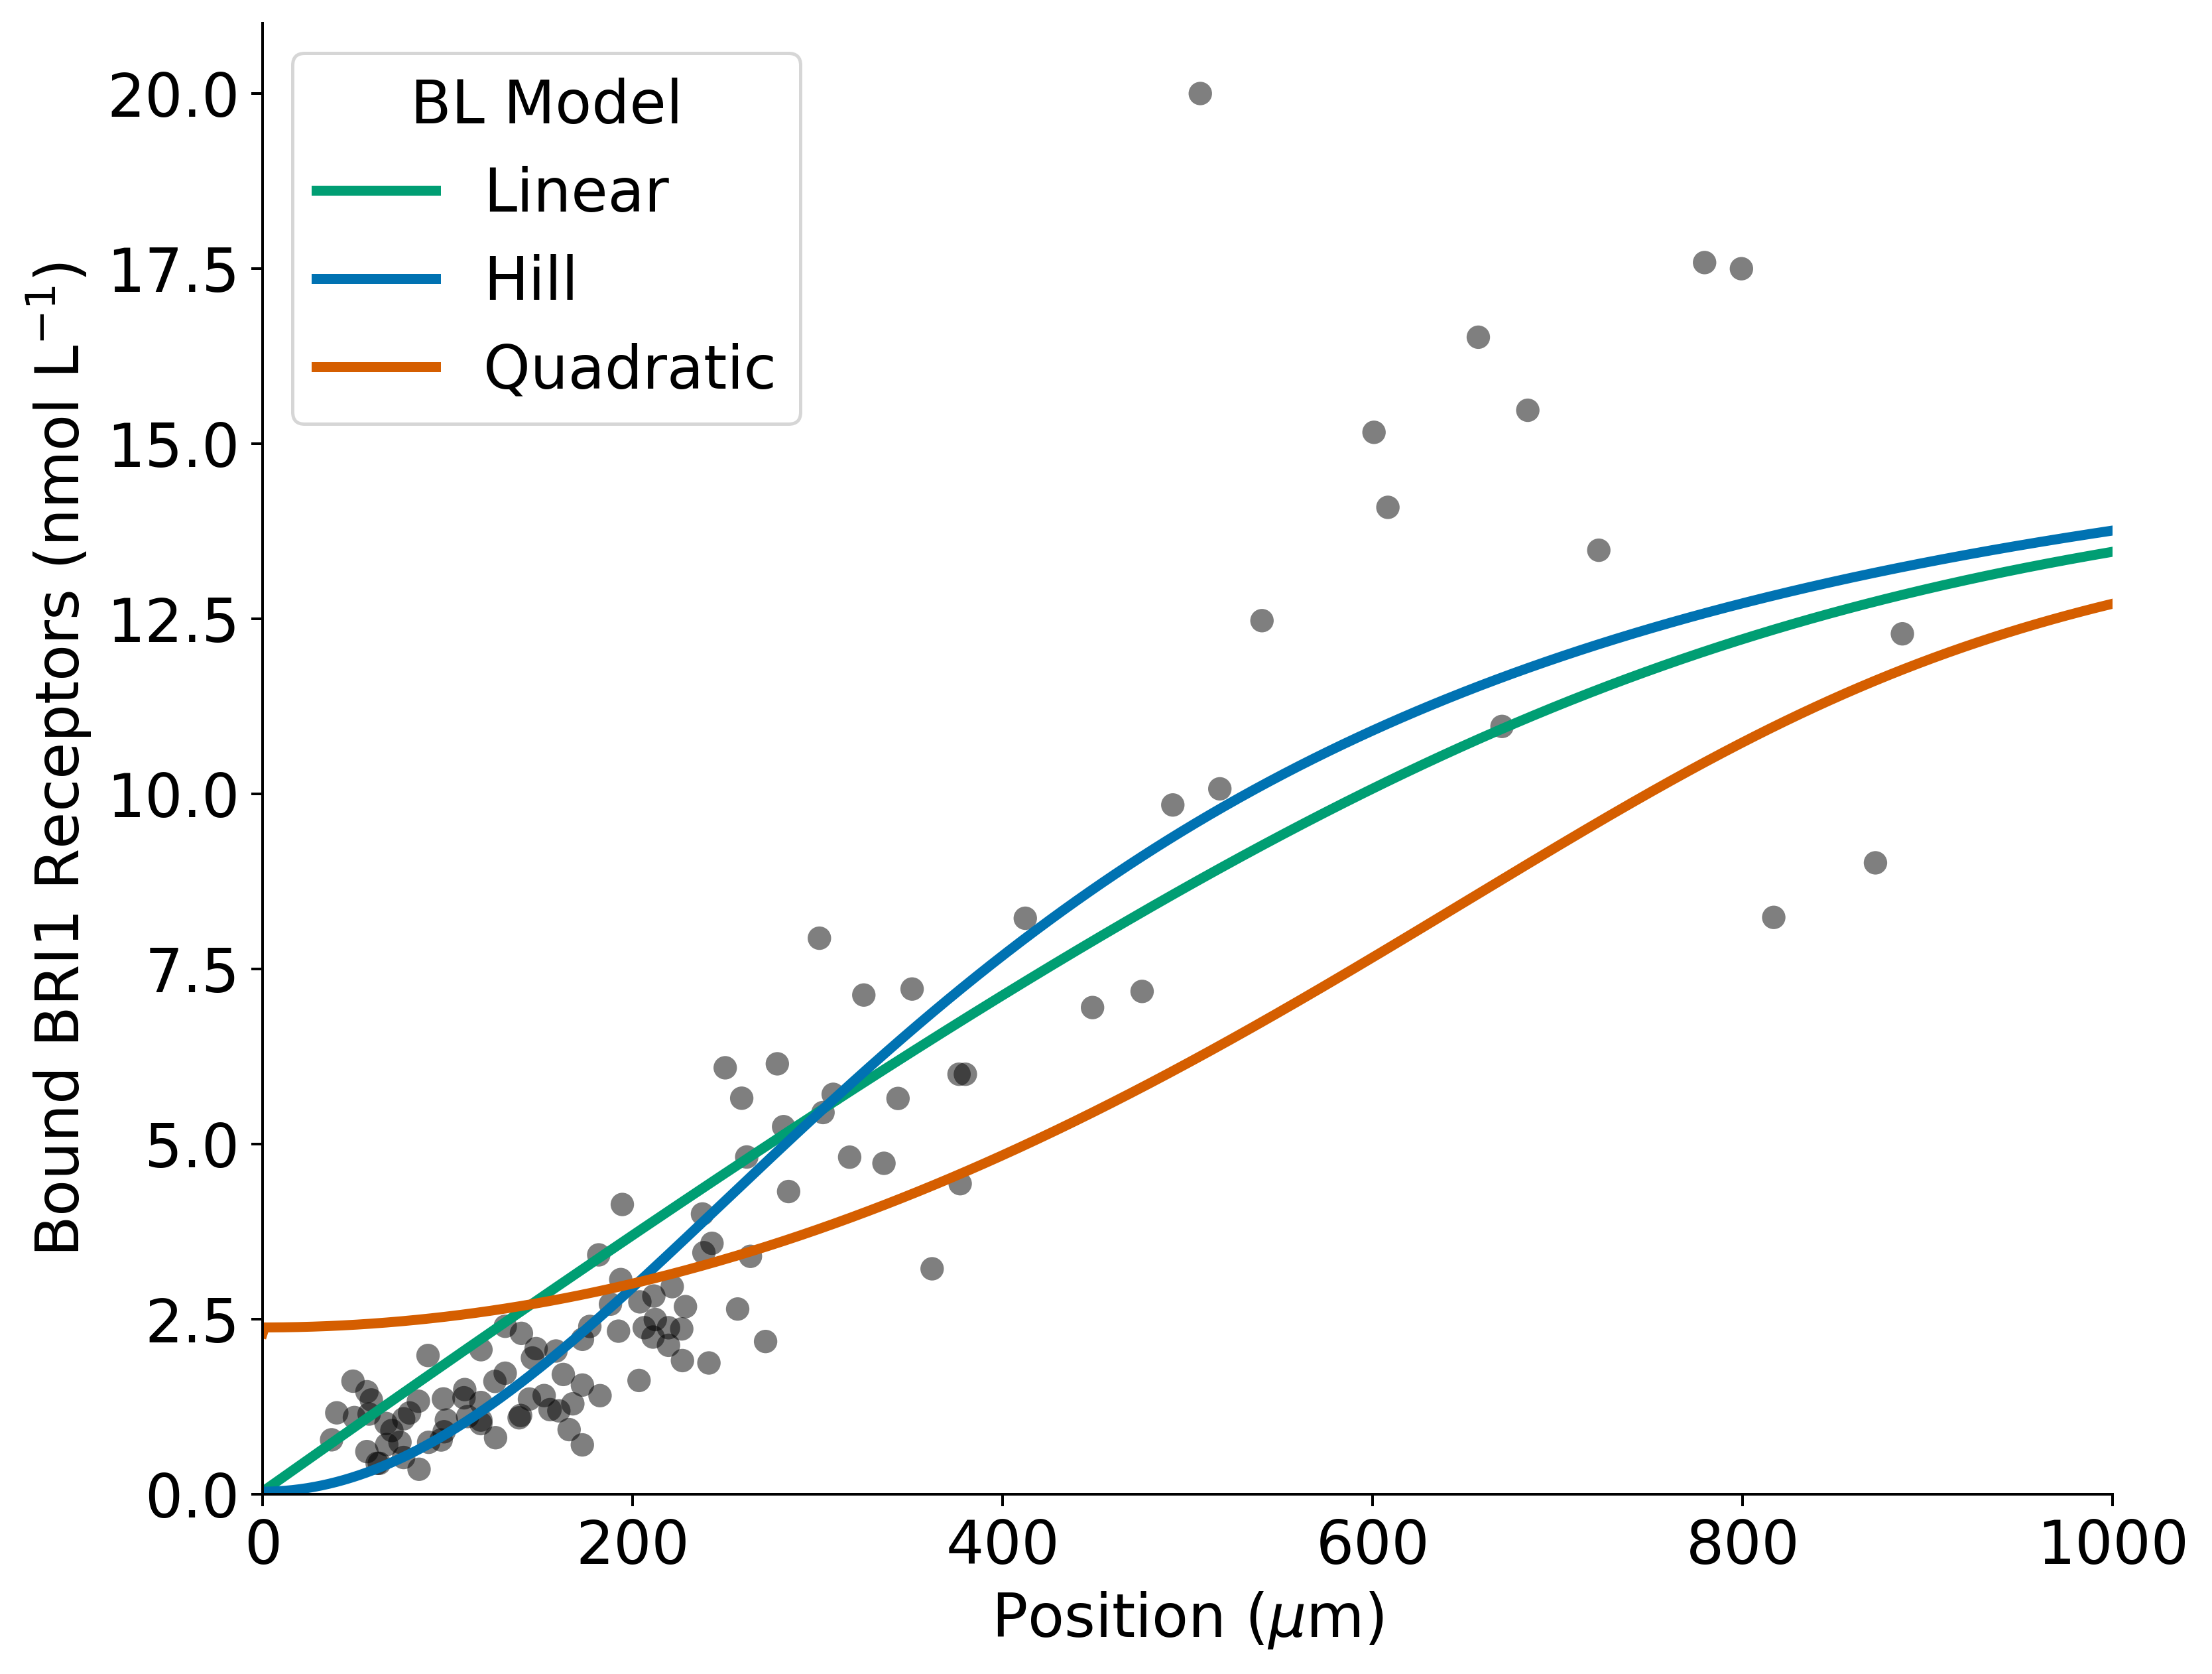

In [6]:
mpl.rcParams['figure.dpi'] = 360
mpl.rcParams['font.size'] = 18
mpl.rcParams['figure.figsize'] = (10, 8)

def plot_models(models):

    ax = plt.subplot(111)
    ax.set_xlabel(r"Position ($\mu\text{m}$)")
    ax.set_ylabel(r"Bound BRI1 Receptors ($\text{nmol L}^{-1}$)")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim((0, 1000))
    ax.set_ylim((0, 1.05 * omega))
    ax.scatter(BES1[:, 0], BES1[:, 1], color = "k", s = 50, alpha = 0.5, edgecolor = "none")
    
    def plot_model(model, label, color):
        (vC, vRT, vRB), fit, rmse = model
        plt.plot(vP, vRB, lw = 3, color = color, label = f"{label}")
    
    labels = ["Linear", "Hill", "Quadratic"]
    colors = [OKABE_ITO[3], OKABE_ITO[5], OKABE_ITO[6]]
    
    for m, l, c in zip(models, labels, colors):
        plot_model(m, l, c )

    l1 = ax.legend(title = "BL Model")
    # plt.savefig(f"{PATH}/bes1-bl-functions.pdf", format ='pdf')

plot_models([model_linear, model_hill, model_quadratic])

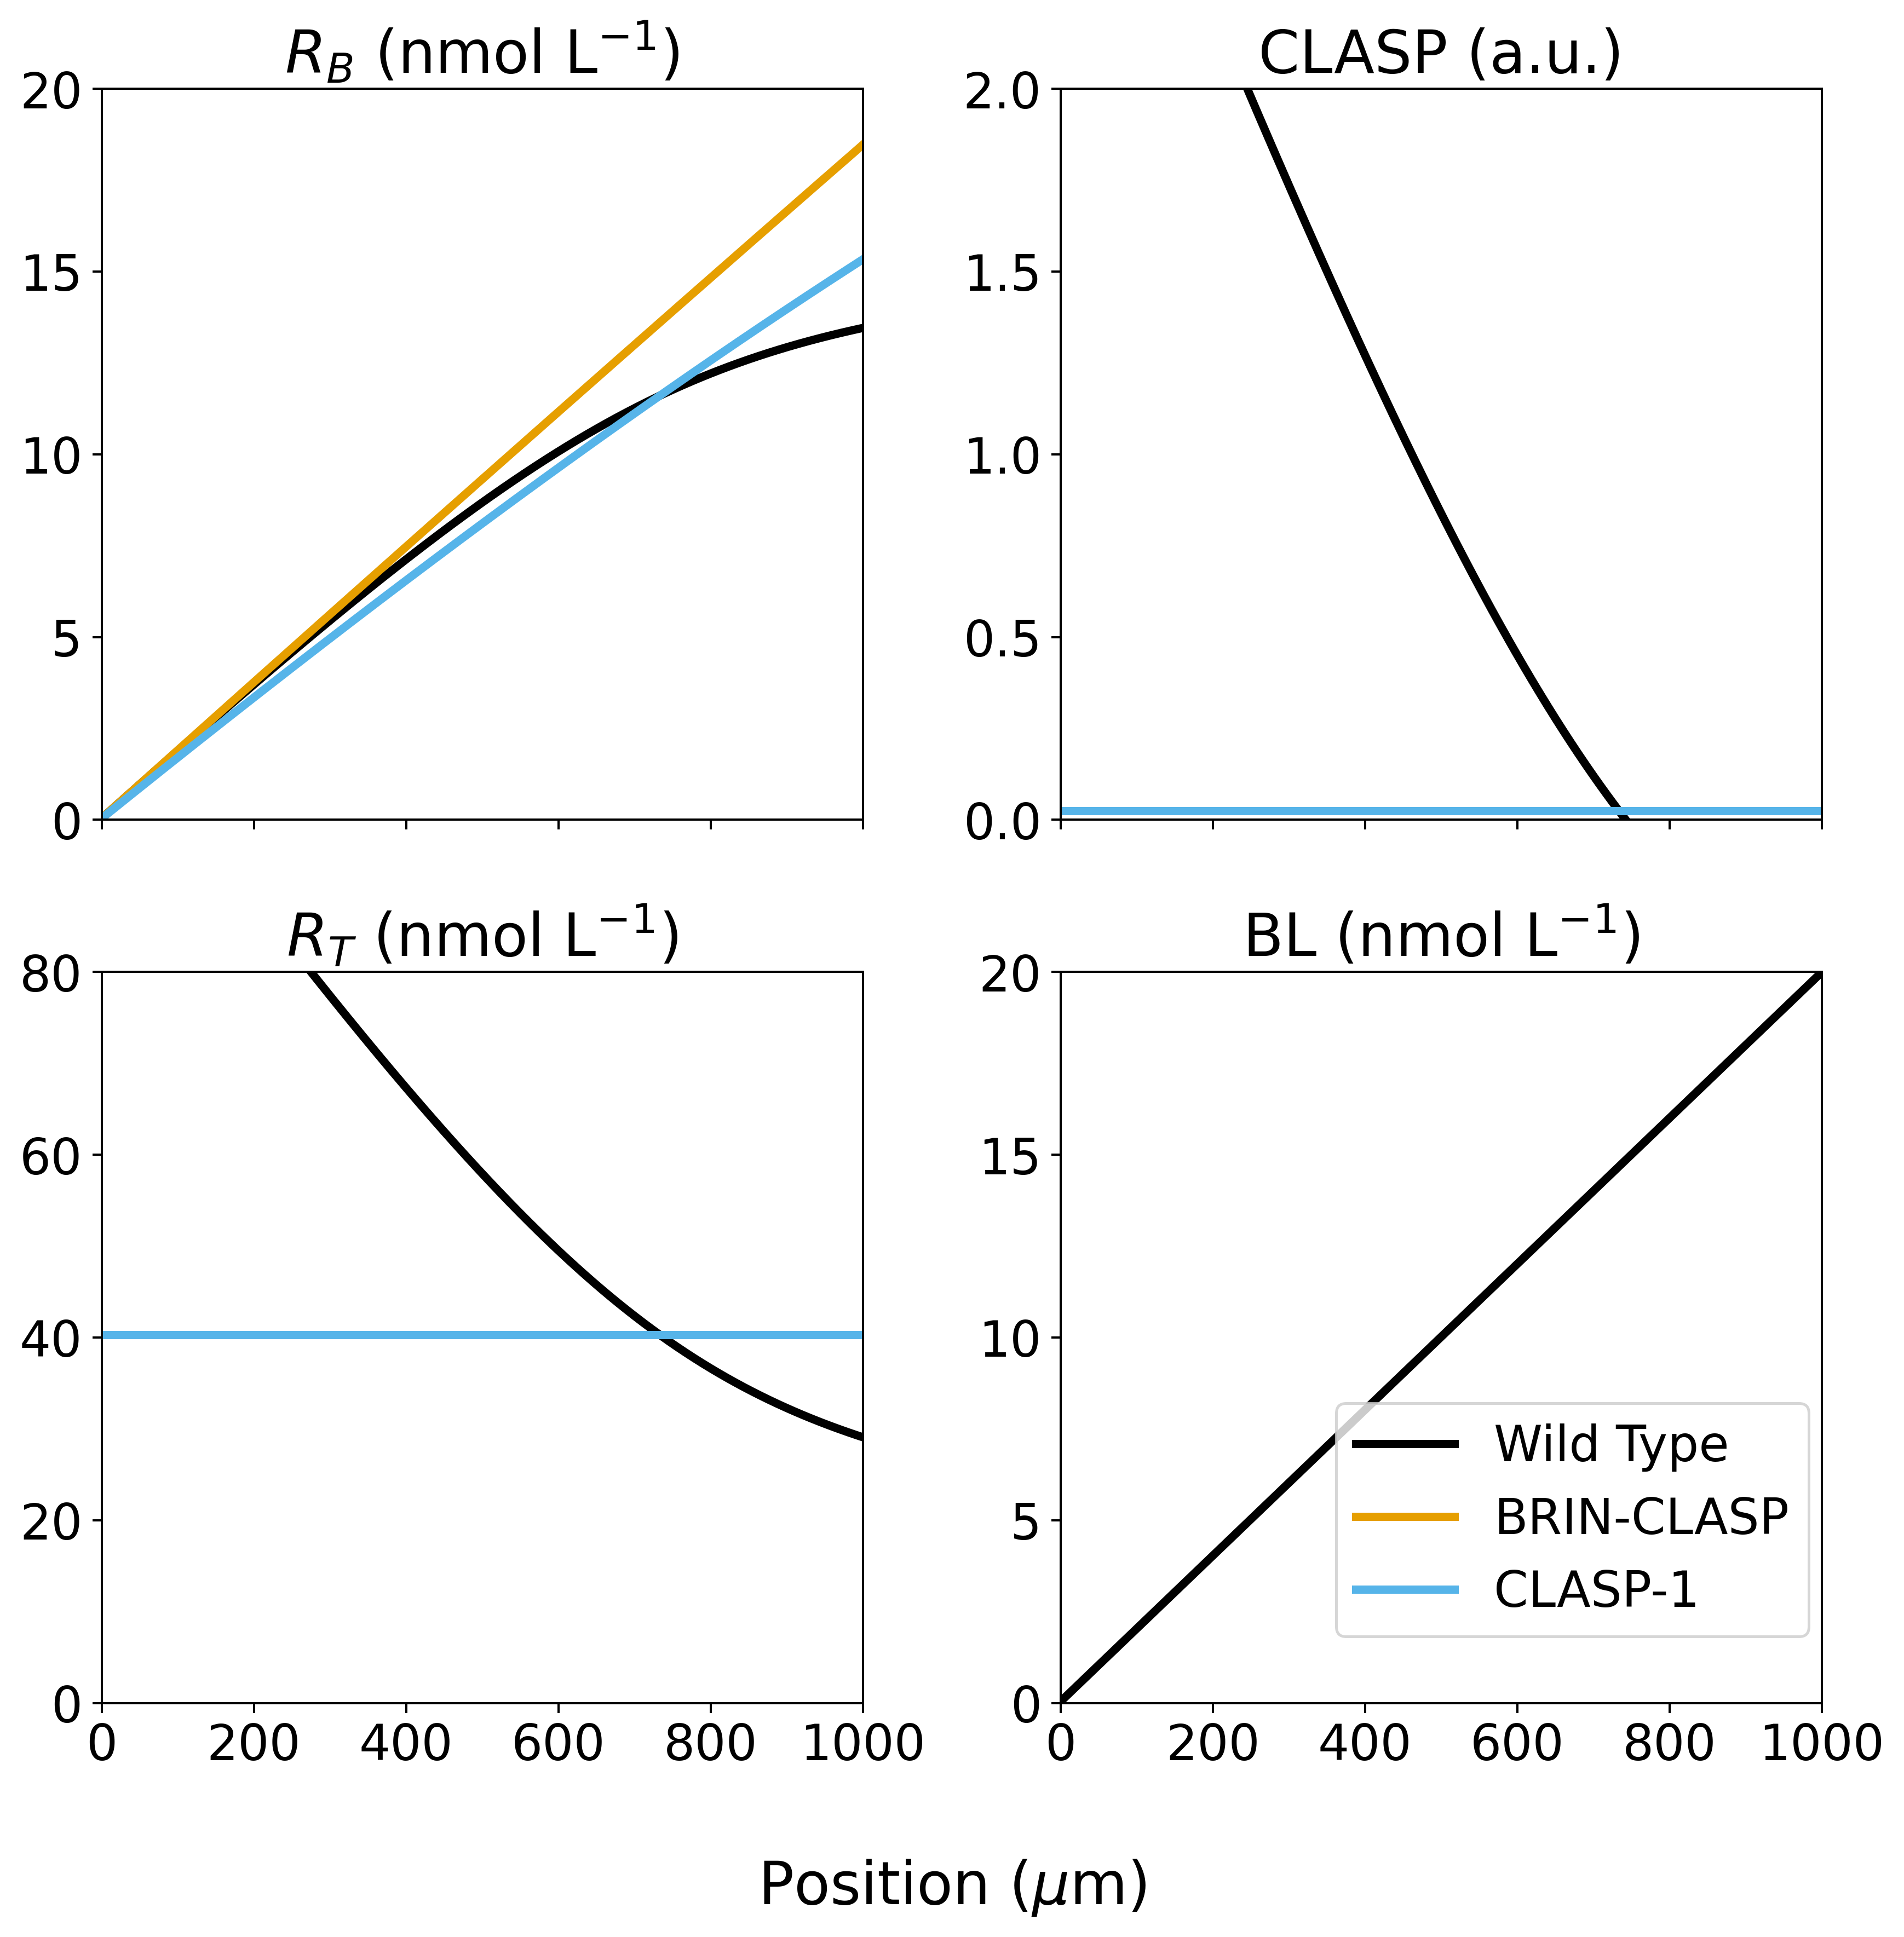

In [7]:
mpl.rcParams['figure.figsize'] = (10, 10)

def plot_best_model(model, func):
    
    *WT, params = model
    BC = simulate(params, omega, "BRIN-CLASP", func, vP)
    C1 = simulate(params, omega, "CLASP-1", func, vP)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, sharex = True, tight_layout = True)

    fig.supxlabel(r"Position ($\mu\text{m}$)")
    ax1.set_title(r"$R_B$ ($\text{nmol L}^{-1}$)")
    ax2.set_title(r"CLASP (a.u.)")
    ax3.set_title(r"$R_T$ ($\text{nmol L}^{-1}$)")
    ax4.set_title(r"BL ($\text{nmol L}^{-1}$)")

    ax1.set_ylim((0, 1 * omega))
    ax2.set_ylim((0, 2))
    ax3.set_ylim((0, 80))  
    ax4.set_ylim((0, 1 * omega))
    
    ax1.set_xlim((0, 1000))
    ax2.set_xlim((0, 1000))
    ax3.set_xlim((0, 1000))
    ax4.set_xlim((0, 1000))
    
    def plot_model(data, label, color):
        
        (vC, vRT, vRB), rmse = data
        ax1.plot(vP[1:], vRB[1:], lw = 3, color = color, label = label)
        ax2.plot(vP[1:], vC[1:] + 0.025, lw = 3, color = color)
        ax3.plot(vP[1:], vRT[1:], lw = 3, color = color)

    datasets = [WT, BC, C1]
    labels = ["Wild Type", "BRIN-CLASP", "CLASP-1"]
    colors = OKABE_ITO[:3]

    for d, l, c in zip(datasets, labels, colors):
        plot_model(d, l, c)
    
    ax4.plot(vP[1:], func(params[0], params[1], vP[1:], omega), lw = 3, color = OKABE_ITO[0])
    fig.legend(bbox_to_anchor=(-0.02, 0.14, 0.967, 0.15), loc = "lower right")
    # plt.savefig(f"{PATH}/bes1-mutants.pdf", format ='pdf')

plot_best_model(model_linear, bl_linear)